## Importing libraries

In [1]:
import classificationModelFunctions # all functions are defined in this module
import calibration_plots_module as cpm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas import set_option
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve

## Loading the data

Loading csv file using pandas.

In [2]:
data_path = "/home/soniya51/Downloads/default of credit card clients.csv"
df = classificationModelFunctions.loadDataAndPrintHead(data_path)

  Unnamed: 0         X1   X2         X3        X4   X5     X6     X7     X8  \
0         ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3   
1          1      20000    2          2         1   24      2      2     -1   
2          2     120000    2          2         2   26     -1      2      0   
3          3      90000    2          2         2   34      0      0      0   
4          4      50000    2          2         1   37      0      0      0   

      X9  ...        X15        X16        X17       X18       X19       X20  \
0  PAY_4  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3   
1     -1  ...          0          0          0         0       689         0   
2      0  ...       3272       3455       3261         0      1000      1000   
3      0  ...      14331      14948      15549      1518      1500      1000   
4      0  ...      28314      28959      29547      2000      2019      1200   

        X21       X22       X23             

## Basic EDA
We see that column names are different from what we'd like them to be. So we rename column names to the first row and delete the first row.

In [3]:
df.columns # Column names before

Index(['Unnamed: 0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19',
       'X20', 'X21', 'X22', 'X23', 'Y'],
      dtype='object')

In [4]:
df = classificationModelFunctions.changeColumnsToFirstRow(df)
print(df.shape)
df.columns # Column names after

(30000, 25)


Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object', name=0)

### Here we check if there are any null values in any of the columns

In [5]:
# basic eda

classificationModelFunctions.checkNullValues(df)

0
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64


### We drop the column 'ID' from the main dataframe and calculate a set of features by dropping the label.

In [6]:
# drop column "ID" and make features
y, features = classificationModelFunctions.makeFeaturesAndLabel(df)
features.shape

(30000, 23)

In [7]:
features.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
1,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
2,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
3,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
4,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
5,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


## Feature engineering

The data has been already encoded and cleaned. However, some categorical data have repeated categories. For instance, the variable ‘education’ has three categories with similar information:
4: others, 5: unknown, and 6: unknown

Similarly, the column 'marriage' should have three categories: 1 = married, 2 = single, 3 = others but it contains a category '0' which will be joined to the category '3'.


In [8]:
# before grouping
print(df['EDUCATION'].unique())
print(df['MARRIAGE'].unique())

['2' '1' '3' '5' '4' '6' '0']
['1' '2' '3' '0']


In [9]:
# after grouping
classificationModelFunctions.groupUnknownCategories(df)
print(df['EDUCATION'].unique())
print(df['MARRIAGE'].unique())

['2' '1' '3' '4']
['1' '2' '3']


### Printing a description of the data

In [10]:
set_option('display.width', 100)
set_option('precision', 2)

print("Stats for columns")
print(df.describe())

Stats for columns
0      LIMIT_BAL    SEX EDUCATION MARRIAGE    AGE  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  ...  \
count      30000  30000     30000    30000  30000  30000  30000  30000  30000  30000  ...   
unique        81      2         4        3     56     11     11     11     11     10  ...   
top        50000      2         2        2     29      0      0      0      0      0  ...   
freq        3365  18112     14030    15964   1605  14737  15730  15764  16455  16947  ...   

0      BILL_AMT4 BILL_AMT5 BILL_AMT6 PAY_AMT1 PAY_AMT2 PAY_AMT3 PAY_AMT4 PAY_AMT5 PAY_AMT6  \
count      30000     30000     30000    30000    30000    30000    30000    30000    30000   
unique     21548     21010     20604     7943     7899     7518     6937     6897     6939   
top            0         0         0        0        0        0        0        0        0   
freq        3195      3506      4020     5249     5396     5968     6408     6703     7173   

0      default payment next month  
count    

## Visualization of the data
We plot some graphs to see the data distribution

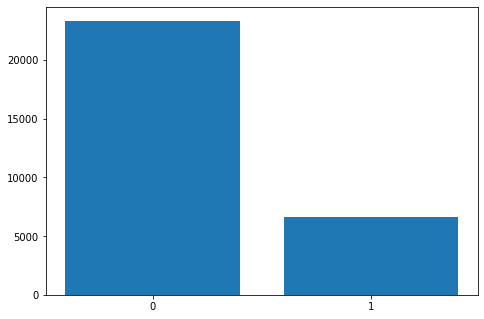

In [11]:
# graph to see the number of default payments

classificationModelFunctions.plotGrapthForDefaults(y)

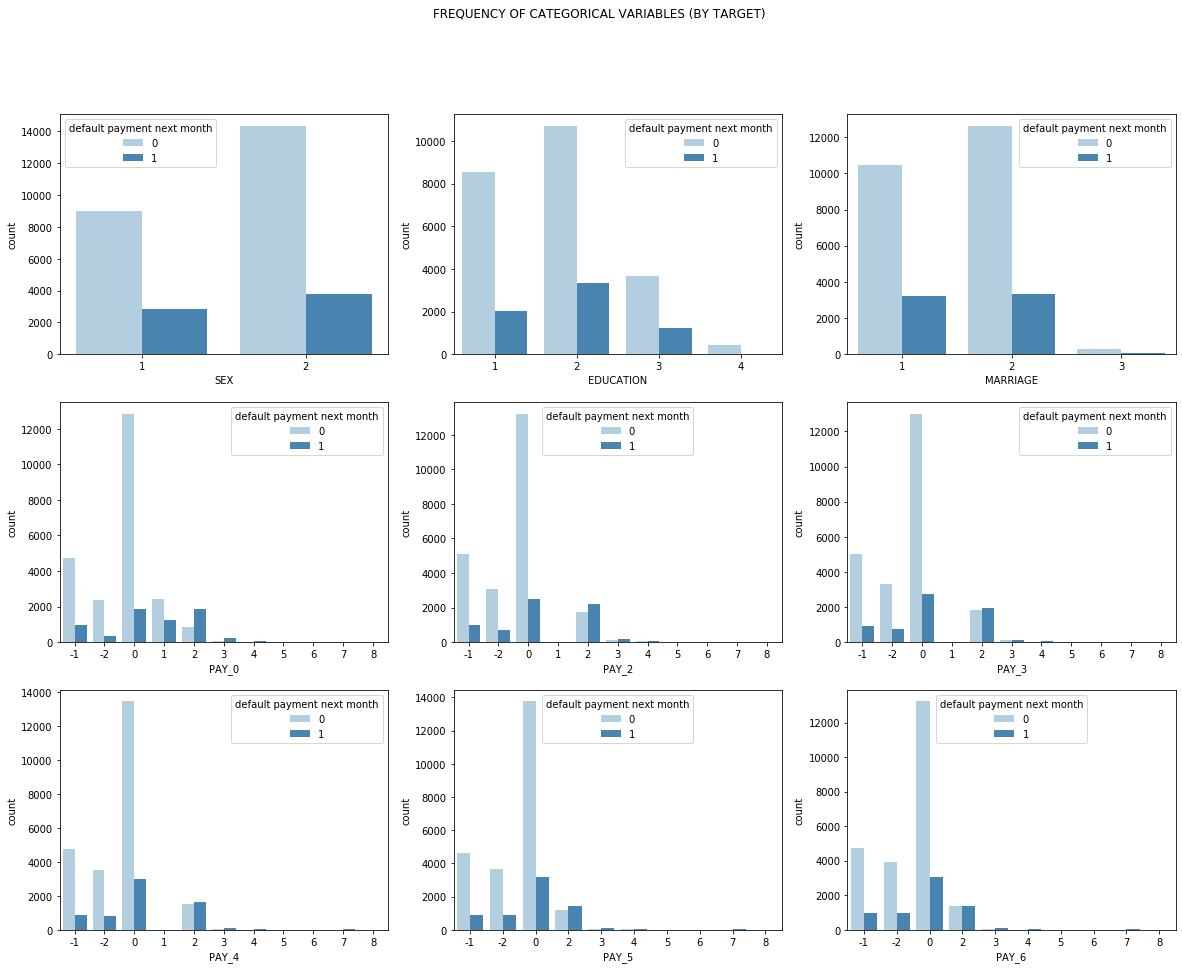

In [12]:
# graphs to visualize more attributes

classificationModelFunctions.plotGrapthForAttributes(df)

In [13]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4',
       'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object', name=0)

There are 30,000 credit card clients.

Education level is mostly graduate school and university.

Most of the clients are either marrined or single (less frequent the other status).

## Splitting the data

Use sklearn to split the data

In [14]:
X_train, X_test, y_train, y_test = classificationModelFunctions.splitData(df, features, y)

## Standardization of data 

All features are centered around zero and have variance one.

In [15]:
X_train['AGE'] = X_train['AGE'].astype(float)
mean = np.mean(X_train['AGE'])
std = np.std(X_train['AGE'])
print(mean, std)
print(X_train.head())

35.500238095238096 9.226798440798328
0     LIMIT_BAL SEX EDUCATION MARRIAGE   AGE PAY_0 PAY_2 PAY_3 PAY_4 PAY_5  ... BILL_AMT3  \
28466    240000   2         1        1  40.0    -2    -2    -2    -2    -2  ...         0   
27623     50000   2         1        2  23.0    -1    -1    -1    -1    -1  ...      2299   
28377     50000   2         2        1  36.0     2     2     2     2     0  ...     49125   
10918    200000   2         3        1  54.0     6     5     4     3     2  ...    104686   
27235    240000   1         1        1  35.0    -1    -1    -1     0    -1  ...     21790   

0     BILL_AMT4 BILL_AMT5 BILL_AMT6 PAY_AMT1 PAY_AMT2 PAY_AMT3 PAY_AMT4 PAY_AMT5 PAY_AMT6  
28466         0         0         0        0        0        0        0        0        0  
27623      4800      9810       660     2548     2321     4800     9810      660     2980  
28377     47956     43578     35126        0     4700        0     2004     3500        0  
10918    102549    101400         0 

/home/soniya51/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
classificationModelFunctions.standardizeData(X_test, X_train)

/home/soniya51/Repos/PRESC/dev/Soniyanayak51/issue5/classificationModelFunctions.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col_to_norm] = standardize(X_test[col_to_norm], X_train[col_to_norm])
/home/soniya51/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/pandas/core/frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/home/soniya51/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/pandas/core/frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy 

0      LIMIT_BAL SEX EDUCATION MARRIAGE   AGE PAY_0 PAY_2 PAY_3 PAY_4 PAY_5  ... BILL_AMT3  \
28466       0.56   2         1        1  0.49    -2    -2    -2    -2    -2  ...     -0.68   
27623      -0.91   2         1        2 -1.35    -1    -1    -1    -1    -1  ...     -0.64   
28377      -0.91   2         2        1  0.05     2     2     2     2     0  ...      0.03   
10918       0.25   2         3        1  2.01     6     5     4     3     2  ...      0.84   
27235       0.56   1         1        1 -0.05    -1    -1    -1     0    -1  ...     -0.36   

0      BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  
28466      -0.67      -0.67      -0.66     -0.33     -0.24     -0.29     -0.30     -0.31     -0.30  
27623      -0.60      -0.50      -0.65     -0.18     -0.15     -0.02      0.31     -0.27     -0.13  
28377       0.08       0.06      -0.06     -0.33     -0.05     -0.29     -0.18     -0.09     -0.30  
10918       0.93       1.01    

## Model 1: Logistic Regression

First, I try a simple logistic regression model for the classification. This is a baseline model and gives an idea if the data is linearly separable.

In [17]:
lr_preds, logisticRegressionScore, logRegModel = classificationModelFunctions.logisticRegressionModel(X_train, y_train, X_test, y_test)

### Accuracy of Logistic Regression model
Check the accuracy for test data

In [18]:
print(logisticRegressionScore)

0.8087777777777778


This accuracy shows that neural networks will overfit the data and simple svm will be a good choice after logistic regression.

## Model 2: SVM model

I use the sklearn svm model(sklearn.svm.SVC). The accuracy is shown with the confusion matrix.

Kernel methods give better results for non-linear binary classifications and we can see that the scatterplot is somewhat not linearly seperable.

In [19]:
SVMScore, prediction_SVM, SVM_Model = classificationModelFunctions.svmModel(X_train, y_train, X_test, y_test)

[LibSVM]

### Accuracy of SVM Model
Check the accuracy for test data

In [20]:
print (SVMScore)

Accuracy - : 0.820


## Confusion matrix
tn - true positives, tp - true negatives, fn - false negatives, fp - false positives

Sensitivity/Recall = TP/(TP + FN). When it’s actually yes, how often does it predict yes? 

Specificity = TN/(TN + FP) .When it’s actually no, how often does it predict no?

Precision = TP/predicted yes. When it predicts yes, how often is it correct?

Analysis of above measures of accuracy for both models.

### 1. Confusion matrix for svm model.

In [21]:
tn, fp, fn, tp = confusion_matrix(y_test, prediction_SVM).ravel()
confusion_matrix(y_test, prediction_SVM)

array([[6717,  323],
       [1300,  660]])

In [22]:
print(tp/(tp+fn)) # Sensitivity/Recall
print(tn/(tn+fp)) # Specificity
print(tp/(tp+fp)) # Precision

0.336734693877551
0.9541193181818182
0.671414038657172






### 2. Confusion matrix for logistic regression model.

In [23]:
tn, fp, fn, tp = confusion_matrix(y_test, lr_preds).ravel()
confusion_matrix(y_test, lr_preds)

array([[6824,  216],
       [1505,  455]])

In [24]:
print(tp/(tp+fn)) # Sensitivity/Recall
print(tn/(tn+fp)) # Specificity
print(tp/(tp+fp)) # Precision

0.23214285714285715
0.9693181818181819
0.6780923994038748


## Results

### Logistic Regression
Test Accuracy - 0.809

### SVM
Test Accuracy - 0.82

## Calibration Plots

I use calibration_curve from sklearn.calibratin plot calibration curves across models.

For binary classification tasks predict_proba returns a matrix containing the first class proba in the first column, and the second class proba in the second column. Since there are only two classes one is just 1 - n of the other.
The calibration_curve implementation expects just one of these classes in an array.

calibration_curve calculates the following:

prob_true - The 'fraction_of_positives' is the percentage of the true probability in each bin. This is determined by looking at what values these points are actually assigned in  y , and it is the emperical truth.

prob_pred - 'mean_predicted_value', is the mean probability of these points belonging to the dominant class reported by the algorithm

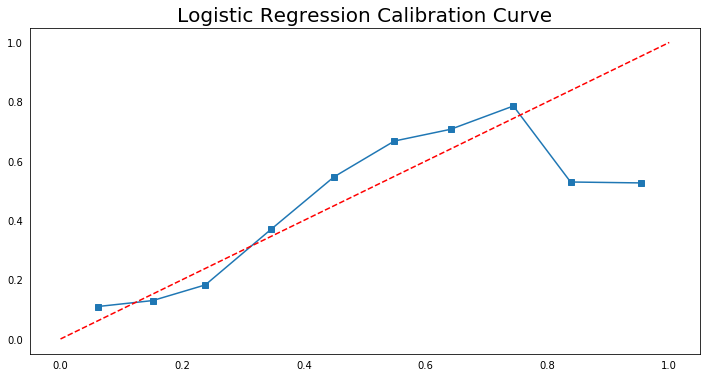

In [25]:
# For logistic Regression
cpm.calibration_plot_for_single_classifier(logRegModel, "Logistic Regression", y_test, X_test)

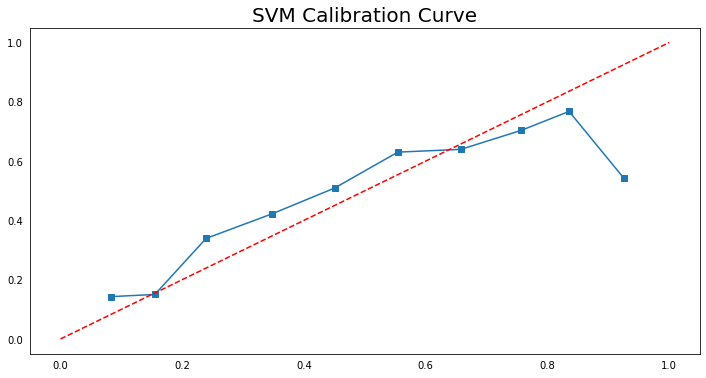

In [26]:
cpm.calibration_plot_for_single_classifier(SVM_Model, "SVM", y_test, X_test)

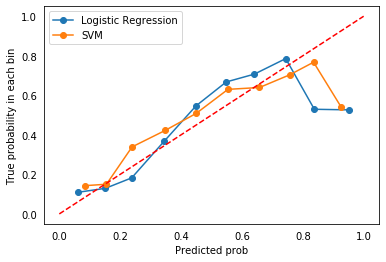

In [27]:
cpm.calibration_plot_for_multiple_classifier([logRegModel, SVM_Model], ['Logistic Regression', 'SVM'], y_test, X_test)